In [1]:
from scipy.integrate import odeint
from plotly.subplots import make_subplots
import numpy as np
import sympy as sy
import IPython
from IPython.display import display
import matplotlib.pyplot as plt

def displayH(a1,a2='', a3='', a4='', a5='', a6='', a7='',):
    latex_a1 = sy.latex(a1)
    latex_a2 = sy.latex(a2)
    latex_a3 = sy.latex(a3)
    latex_a4 = sy.latex(a4)
    latex_a5 = sy.latex(a5)
    latex_a6 = sy.latex(a6)
    latex_a7 = sy.latex(a7)
    display( IPython.core.display.Math(latex_a1 + latex_a2 + latex_a3 + latex_a4 + latex_a5 + latex_a6 + latex_a7)  )

$\newpage$

## Problem:
Design of a software module to assess disturbance torques and simulate the uncontrolled attitude dynamics of a satellite under their influence.

Consider a satellite orbiting the Earth $(\mu = 398600.4418 \, \text{km}^3/\text{s}^2, R_e = 6371 \, \text{km}, \omega_e = 7.2921159 \times 10^{-5} \, \text{rad/s})$, with Earth-Centered-Inertial (ECI) position and velocity vector at time $t_0$ given by:

$$
r(t_0) =
\left[
\begin{array}{c}
6930 \\
0 \\
0 
\end{array}
\right] 
\text{km},
\dot{r}(t_0) =
\left[
\begin{array}{c}
0 \\
5.3895 \\
5.3895 
\end{array}
\right]
\text{km/s}.
$$

The satellite is modeled as a rectangular parallelepiped with sides $x = 1.7 \, \text{m}, y = 1 \, \text{m}, \text{and } z = 1.7 \, \text{m}$. A body-fixed frame is attached to the satellite with the frame origin at the satellite center of mass, and the frame axes are aligned with the principal frame.

The satellite Moment of Inertia (MOI) matrix is:

$$
I =
\left[
\begin{array}{ccc}
I_1 & 0 & 0 \\
0 & I_2 & 0 \\
0 & 0 & I_3 
\end{array}
\right]
=
\left[
\begin{array}{ccc}
50 & 0 & 0 \\
0 & 100 & 0 \\
0 & 0 & 50 
\end{array}
\right] \text{kg m}^2.
$$

We will be considering disturbance forces on only three sides of the satellite:

* Plate 1
    - Unit normal: $\hat{b}_1$.
    - Plate area: $y \ast z$.
    - Perpendicular distance of the Center of Pressure (CP) from the center of mass: $r_{\text{cp}_1} = 0.2 \, \text{m}$.

* Plate 2
    - Unit normal: $\hat{b}_2$.
    - Plate area: $z \ast x$.
    - Perpendicular distance of the Center of Pressure (CP) from the center of mass: $r_{\text{cp}_1} = 0.1 \, \text{m}$.

* Plate 3
    - Unit normal: $\hat{b}_3$.
    - Plate area: $x \ast y$.
    - Perpendicular distance of the Center of Pressure (CP) from the center of mass: $r_{\text{cp}_1} = 0 \, \text{m}$.

Other simulation parameters are provided in the following table:

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Parameter} & \textbf{Value} & \textbf{Description} \\ \hline
t_0 & 0 & \text{[sec], initial time} \\ \hline
dt & 1 & \text{[sec], time-step} \\ \hline
t_f & 3.5 & \text{[hrs], final time} \\ \hline
C_d & 2.2 & \text{[-], drag coefficients for all plates} \\ \hline
P_{\text{sol}} & 4.644 \times 10^{-6} & \text{[N/m}^2\text{], solar pressure} \\ \hline
\rho_s & 0.55 & \text{[-], specular coefficient for all plates} \\ \hline
\rho_d & 0.2 & \text{[-], diffuse coefficient for all plates} \\ \hline
B_0 & 3.12 \times 10^{-5} & \text{[T], magnetic field constant} \\ \hline
\left[\begin{array}{l} d_1 \\ d_2 \\ d_3 \end{array}\right] & 
\left[\begin{array}{l} 1 \\ 1.2 \\ 0.8 \end{array}\right] & 
\text{[Am}^2\text{], residual dipole moment for plates 1, 2, and 3} \\ \hline
\left[\begin{array}{l} \omega_1(t_0) \\ \omega_2(t_0) \\ \omega_3(t_0) \end{array}\right] & 
\left[\begin{array}{l} 0 \\ 0 \\ 0 \end{array}\right] & 
\text{[rad/s], initial angular velocity of the satellite} \\ \hline
\end{array}
$$

You may assume that at time $t_0 = 0$, the $x$-axis of the Earth-Centered-Earth-Fixed (ECEF) frame is aligned with the vernal equinox, i.e., the ECI and the ECEF frames are aligned at the initial time.

In [2]:
mu = 398600.4418
Re = 6371
wE = 7.2921159e-5

rECI_0 = np.array([6930,0,0])
vECI_0 = np.array([0,5.3895,5.3895])
wBODY_0 = np.array([0,0,0])

x = 1.7
y = 1
z = 1.7

I = np.array([[50,0,0],
              [0,100,0],
              [0,0,50]])

t0 = 0
dt = 1
tf = 3.5*3600

Cd = 2.2
P_sol = 4.644e-6
s_specular = 0.55
s_diffuse = 0.2
B0 = 3.12e-5
d = np.array([1,1.2,0.8])

# Plate 1
A1 = y*z
r1_cp = 0.2

# Plate 2
A2 = z*x
r2_cp = 0.1

# Plate 3
A3 = x*y
r3_cp = 0

times = np.arange(t0,tf,0.1)
tol = 1e-12
xECI_0 = np.hstack([rECI_0,vECI_0])

$\newpage$

## 1. Orbit Propagation
The Kepler's two-body equation is provided below:
$$
\ddot{\textbf{r}}=-\frac{\mu}{||\textbf{r}||^3}\textbf{r}
$$
Perform the following tasks:

### (a) State-Space Form
Convert the three second-order differential equations (for  ̈X,  ̈Y , and  ̈Z) into six first-order differential equations, i.e., express the differential equations in the state-space form.
$$
\textbf{x} = \left[\begin{array}{c}
r_x \\
r_y \\
r_z \\
v_x \\
v_y \\
v_z 
\end{array}\right]
$$

$$
\dot{\textbf{x}} = \left[\begin{array}{c c c c c c}
0&0&0&1&0&0 \\
0&0&0&0&1&0 \\
0&0&0&0&0&1 \\
-\frac{\mu}{||\textbf{r}||^3}&0&0&0&0&0 \\
0&-\frac{\mu}{||\textbf{r}||^3}&0&0&0&0 \\
0&0&-\frac{\mu}{||\textbf{r}||^3}&0&0&0
\end{array}\right]
\left[\begin{array}{c}
r_x \\
r_y \\
r_z \\
v_x \\
v_y \\
v_z 
\end{array}\right]
$$

$\newpage$

### (b) Numerical Integration
Numerically integrate the two-body equation over a period of 3.5 hours using the given initial conditions and the time vector parameters.

In [3]:
def Translation_EOM(x,t,mu):
    A = -mu/np.linalg.norm(x[:3])**3
    return np.array([[0,0,0,1,0,0],
                     [0,0,0,0,1,0],
                     [0,0,0,0,0,1],
                     [A,0,0,0,0,0],
                     [0,A,0,0,0,0],
                     [0,0,A,0,0,0]])@x

xECI = odeint(Translation_EOM,xECI_0,times,rtol=tol,atol=tol,args=(mu,))

### (c) Plotting (2d)
Plot the time histories of the position vector components, i.e., plot X(t), Y (t), and Z(t) as functions of time.

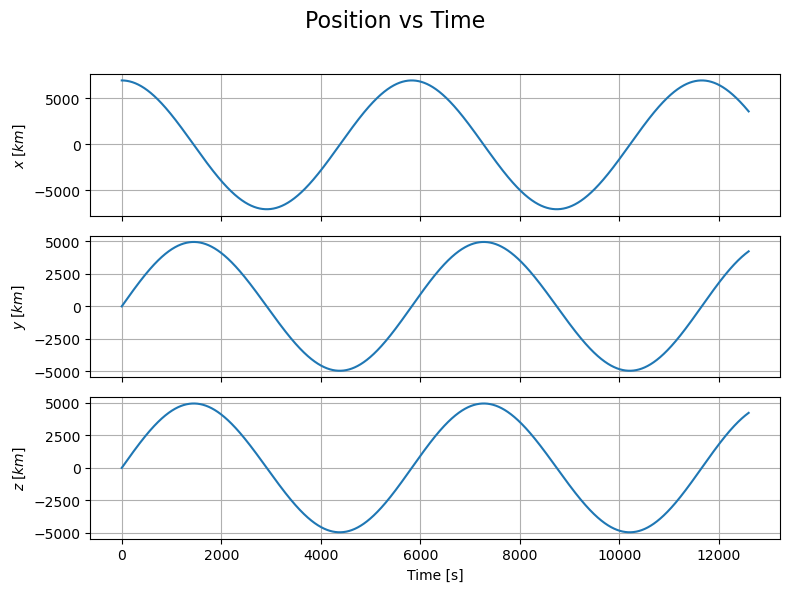

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, label in enumerate(["x","y","z"]):
    axes[i].plot(times, xECI[:,i])
    axes[i].set_ylabel(f"${label}\\;[km]$")
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Position vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

$\newpage$

### (d) Plotting (3d)
Plot the 3D orbit of the satellite, i.e., plot X(t), Y (t), and Z(t) in the inertial frame.

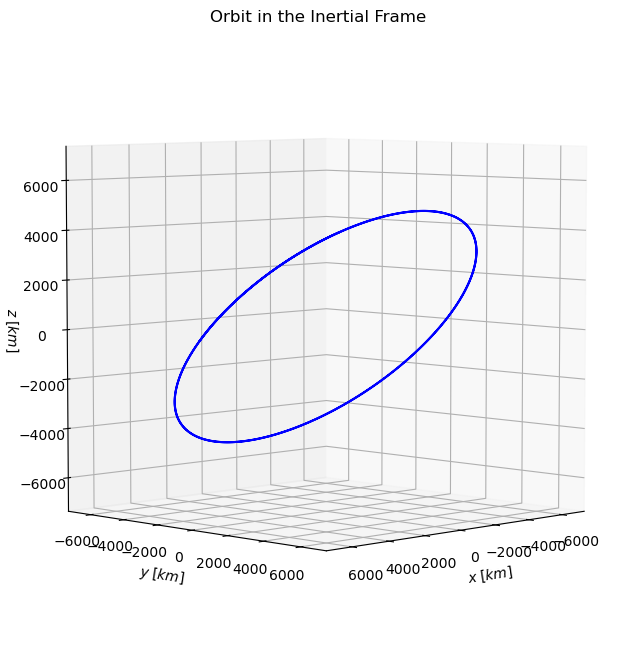

In [73]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xECI[:, 0], xECI[:, 1], xECI[:, 2], color='b')
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('$x\\;[km]$')
ax.set_ylabel('$y\\;[km]$')
ax.set_zlabel('$z\\;[km]$')
max_val = np.max(np.abs(xECI[:, :3]))
ax.set_xlim([-max_val,max_val])
ax.set_ylim([-max_val,max_val])
ax.set_zlim([-max_val,max_val])
ax.set_title('Orbit in the Inertial Frame')
ax.view_init(elev=5, azim=45)
plt.show()

$\newpage$

## 2. Aerodynamic Torque
The expression for the aerodynamic force on plate i derived in class was,
$$
\textbf{F}_i^{aero} = -\frac{1}{2}\rho C_d ||\textbf{v}_{rel}|| \textbf{v}_{rel} A_i max\{cos(\theta_i),0\}
$$
where, \
$\rho$ is the atmospheric density \
$C_d$ is the dimensionless drag coefficient \
$\textbf{v}_{rel}$ is the relative velocity of the spacecraft wrt the atmospheric particles in the body frame

$$
\textbf{v}_{rel} = [C]^B_{ECI} \left(\begin{array}{c}
\dot{X}+\omega_E Y \\
\dot{Y}-\omega_E X \\
\dot{Z}
\end{array}\right)
$$

The atmospheric density $\rho$ in the aerodynamic force equation can be computed as
follows:
$$
T = −131.21 + 2.99h
$$
$$
P = 2.488 \left(\frac{T+273.1}{216.6}\right)^{-11.388}
$$
$$
\rho = \frac{P}{0.2869(T+273.1)}
$$
where,

$T$ is the atmospheric temperature [deg C] \
$h$ is the altitude of the satellite above the surface of the Earth [km] \
$P$ is the atmospheric pressure [kPa] \
$\rho$ is the atmospheric density [kg/m^3]

At this point, we will make the following simplifying assumptions:
1. At every point in orbit the atmospheric particles hit the surface of the spacecraft
perpendicularly, i.e., $cos(\theta_i) = 1$.
2. The direction cosines matrix $[C]^B_{ECI} = I_{3\times 3}$

This gives us the following expression for the magnitude of the aerodynamic force on
plate i:
$$
\textbf{F}_i^{aero} = \frac{1}{2}\rho C_d ||\textbf{v}_{rel}||^2 A_i
$$
with,
$$
\textbf{v}_{rel} = \left(\begin{array}{c}
\dot{X}+\omega_E Y \\
\dot{Y}-\omega_E X \\
\dot{Z}
\end{array}\right) \text{... relative velocity in [km/s]}
$$

The magnitude of the aerodynamic torque on plate i can then be computed using
the equation,
$$
\tau_i^{aero} = r_i^{cp}F_i^{aero}
$$

Perform the following tasks:

### (a) Numerical Integration and Plotting
Using the numerically integrated values for $r(t)$ and $\dot{r}(t)$ from the orbit propagation, compute the values for $\tau_i^{aero}$ on the three plates. Plot these values.

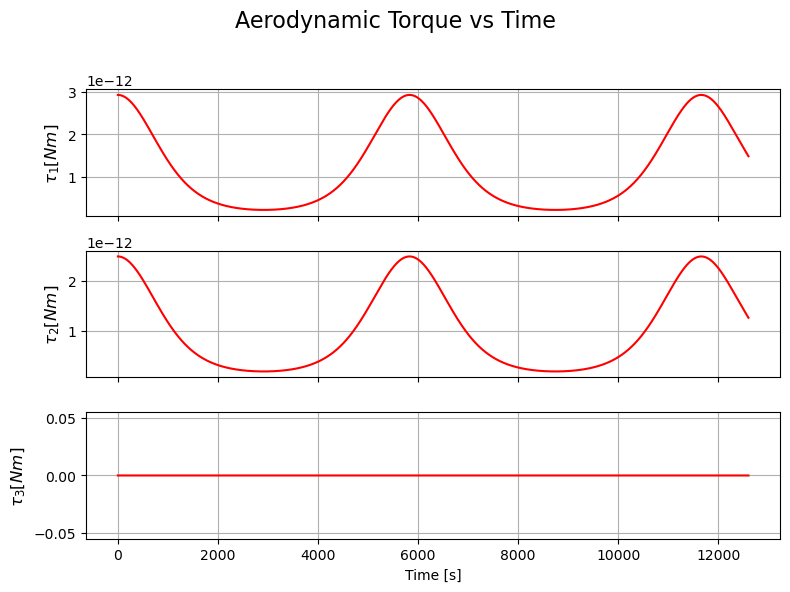

In [89]:
v_rel = np.array([[state[3]+wE*state[1],
                   state[4]-wE*state[0],
                   state[5]] for state in xECI])

h = np.linalg.norm(xECI[:,:3],axis=1)-Re
T = -131.21+2.99*h
P = 2.488*((T+273.1)/216.6)**(-11.388)
rho = P/(0.2869*(T+273.1))

F_aero_1 = 0.5*rho*Cd*np.linalg.norm(v_rel,axis=1)**2*A1
F_aero_2 = 0.5*rho*Cd*np.linalg.norm(v_rel,axis=1)**2*A2
F_aero_3 = 0.5*rho*Cd*np.linalg.norm(v_rel,axis=1)**2*A3

L_aero_1 = r1_cp*F_aero_1
L_aero_2 = r2_cp*F_aero_2
L_aero_3 = r3_cp*F_aero_3

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, L in enumerate([L_aero_1, L_aero_2, L_aero_3]):
    axes[i].plot(times,L, color='red')
    axes[i].set_ylabel(f"$\\tau_{i+1} [Nm]$",fontsize=12)
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Aerodynamic Torque vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### (b) Comments
Provide your comments on the plot.

What we see in this plot is that both Plates 1 and 2 generate a small amount of Aerodynamic Torque, whereas Plate 3 does not generate any Aerodynamic Torque. This makes sense, as the torque moment arm for Plate 3, $r^{cp}_i = 0$. Additionally, we see that the torque oscillates as the satellite progresses through its orbit. We can see that both Plates 1 and 2's torque start ($t=t_0$) at its maximum value, where the orbit is at its perigee, then makes its way to its minimum value at the orbit apogee, finally returning back to its maximum back at the orbit perigee.

### (c) Specific Values
Provide the numerical values for the following three quantities at the initial time of your simulation,

1. Altitude $h(t_0) [km]$.
2. Atmospheric density $\rho(t_0) [kg/m^3]$.
3. Relative velocity magnitude $v_{rel}(t_0) [m/s]$.

In [7]:
displayH(sy.Symbol("h(t_0) ="),h[0],sy.Symbol("[km]"))
displayH(sy.Symbol(r"\rho(t_0) ="),rho[0],sy.Symbol("[kg/m^{3}]"))
displayH(sy.Symbol(r"v_{rel}(t_0) ="),np.linalg.norm(v_rel[0]),sy.Symbol("[m/s]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$\newpage$

## 3. Solar Radiation Pressure Torque
The expression for the Solar Radiation Pressure (SRP) force on the plate i derived in class was,
$$
\textbf{F}_i^{srp} = -P_{sol}A_i \left[(1-\rho_s)\hat{\textbf{s}}+2\left(\rho_s cos(\theta_i)+\frac{\rho_d}{3}\right)\hat{\textbf{n}}_i\right] max\{cos(\theta_i),0\}
$$
where,\
$P_{sol}$ is the solar pressure. \
$\rho_s$ is the specular coefficient (same for all plates) \
$\rho_d$ is the diffuse coefficient (same for all plates)

For the SRP force, we will make the following simplifying assumption:

1. At every point in the orbit, the photons hit the surface of the spacecraft perpendicularly, i.e., $\hat{\textbf{s}} = \hat{\textbf{n}}_i$ and $cos(\theta_i) = 1$.

This gives us the following simplified expression for the magnitude of the SRP force
on plate i,
$$
\textbf{F}_i^{srp} = P_{sol}A_i\left(1+\rho_s + \frac{2}{3}\rho_d\right)
$$
Just like the previous case, the magnitude of the SRP torque on plate i can be
computed using the equation:
$$
\tau_i^{srp} = r_i^{cp}F_i^{srp}
$$

Perform the following tasks:

### (a) Computation and Plotting
Compute and plot the time histories for $\tau^{srp}_i$ on the three plates i = 1, 2, 3.

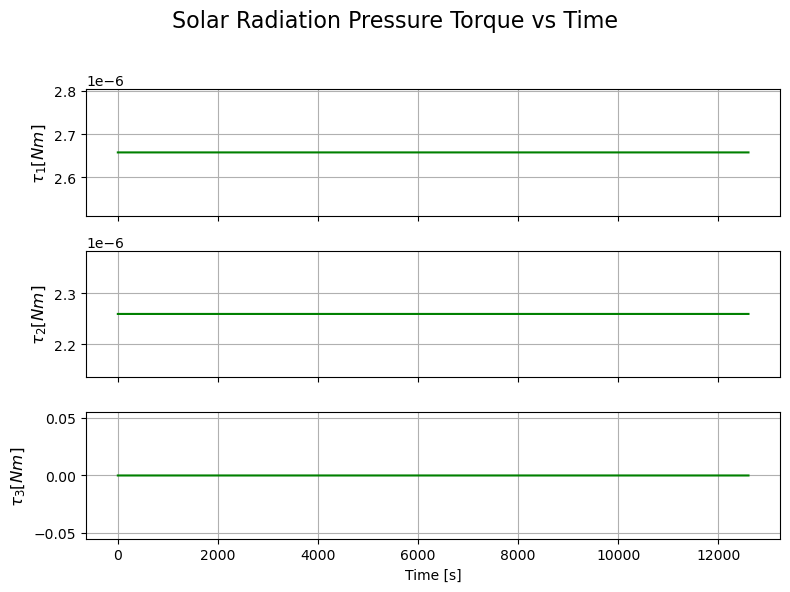

In [8]:
F_srp_1 = P_sol*A1*(1+s_specular+2/3*s_diffuse)
F_srp_2 = P_sol*A2*(1+s_specular+2/3*s_diffuse)
F_srp_3 = P_sol*A3*(1+s_specular+2/3*s_diffuse)

L_srp_1 = r1_cp*F_srp_1
L_srp_2 = r2_cp*F_srp_2
L_srp_3 = r3_cp*F_srp_3

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, L in enumerate([L_srp_1, L_srp_2, L_srp_3]):
    axes[i].plot(times, np.ones_like(times)*L, color='green')
    axes[i].set_ylabel(f"$\\tau_{i+1} [Nm]$",fontsize=12)
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Solar Radiation Pressure Torque vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### (b) Specific Values
Provide the following SRP torque values at the initial time:

1. $\tau_1^{srp}(t_0) [Nm]$
2. $\tau_2^{srp}(t_0) [Nm]$
3. $\tau_3^{srp}(t_0) [Nm]$

In [9]:
displayH(sy.Symbol(r"\tau_1^{srp}(t_0) ="),L_srp_1,sy.Symbol("[Nm]"))
displayH(sy.Symbol(r"\tau_2^{srp}(t_0) ="),L_srp_2,sy.Symbol("[Nm]"))
displayH(sy.Symbol(r"\tau_3^{srp}(t_0) ="),L_srp_3,sy.Symbol("[Nm]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### (c) Comments
Provide your comments on these values.

From these values, we see that the $\hat{b}_1$ axis provides the most amount of torque, followed by the $\hat{b}_2$ axis, and finally the $\hat{b}_3$ axis provides 0 torque, as the moment arm for the force is 0. This makes sense, as the we assumed the same constants for each plate, so the only difference is with the plate areas and the moment arms. Additionally, we also see that SRP torque values are constant with time due to the assumptions that we are making in the problem.

$\newpage$

## 4. Magnetic Field Torque
We will use a highly simplified dipole model of the Earth’s magnetic field to calculate the magnetic field torque. The strength of the magnetic field is a function of the radial distance from the Earth and the latitude of the satellite. The magnetic field intensity is found using the equation,
$$
B = B_0 \left( \frac{R_e}{\|\mathbf{r}\|} \right)^3 \sqrt{1 + 3 \cos^2 \lambda}
$$
where, $B_0 = 3.12 \times 10^{-5} \, \text{T}$ is the magnetic field constant.

$$
\lambda = \tan^{-1} \left( \frac{z_{\text{ecef}}}{\sqrt{x_{\text{ecef}}^2 + y_{\text{ecef}}^2}} \right)
$$
is the latitude of the satellite, with $\mathbf{r}_{\text{ecef}} = 
\begin{pmatrix}
x_{\text{ecef}} \\
y_{\text{ecef}} \\
z_{\text{ecef}}
\end{pmatrix}$
being the position vector of the satellite in the ECEF frame.

Under the further simplifying assumption that the residual dipole vector for all plates is perpendicular to the magnetic field at all times, the disturbance torque on plate i of the satellite can then be found by multiplying $B$ by the residual dipole for the plate, $d_i$:
$$
\tau_i^{\text{mag}} = d_i B
$$

Perform the following tasks:

$\newpage$

### (a) Computation and Plotting
Use the numerically integrated values for $\mathbf{r}(t) = \left[\begin{array}{c}X(t) \\ Y(t) \\ Z(t)\end{array} \right]$ from the orbit propagation to compute the values for $\tau_i^{mag}$ on the three plates i=1,2,3. Plot these values.

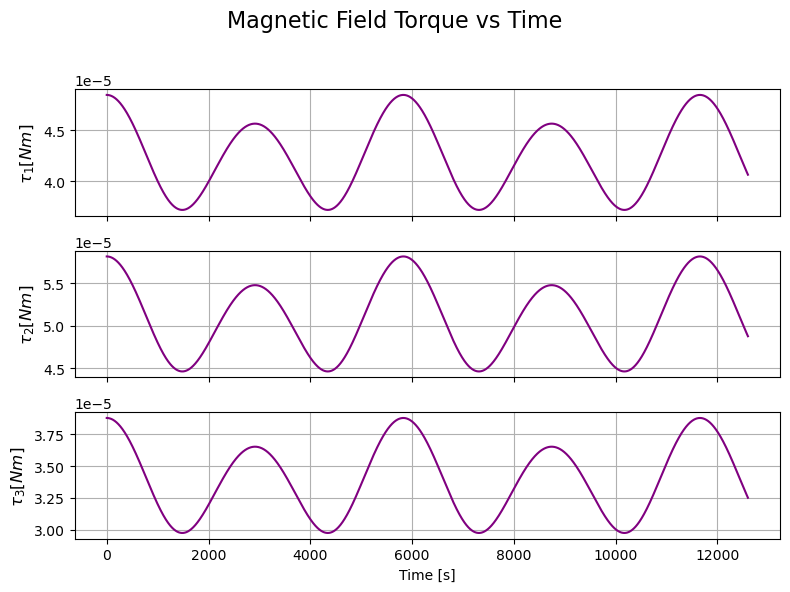

In [10]:
T_ECI_to_ECEF = np.array([[[np.cos(gamma),np.sin(gamma),0],
                           [-np.sin(gamma),np.cos(gamma),0],
                           [0,0,1]] for gamma in wE*times])
rECEF = np.array([T@r for T,r in zip(T_ECI_to_ECEF,xECI[:,:3])])
lat = np.array([np.arctan2(z,(x**2+y**2)**0.5) for x,y,z in rECEF])

B = B0*(Re/np.linalg.norm(rECEF,axis=1))**3*(1+3*np.cos(lat)**2)**0.5
L_mag_1 = d[0]*B
L_mag_2 = d[1]*B
L_mag_3 = d[2]*B

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, L in enumerate([L_mag_1, L_mag_2, L_mag_3]):
    axes[i].plot(times, L, color='purple')
    axes[i].set_ylabel(f"$\\tau_{i+1} [Nm]$",fontsize=12)
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Magnetic Field Torque vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### (b) Specific Values
Provide the numerical values for the two following quantities at the initial time of your simulation.

1. Latitude $\lambda(t_0) [deg]$
2. Magnetic Field Intensity $B(t_0) [T]$

In [11]:
displayH(sy.Symbol(r"\lambda(t_0) ="),np.degrees(lat[0]),sy.Symbol("[deg]"))
displayH(sy.Symbol("B(t_0) ="),B[0],sy.Symbol("[T]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$\newpage$

## 5. Gravity-Gradient Torque
The gravity-gradient torque equation derived in class is,
$$
\left[\begin{array}{c}
\tau_1^g \\
\tau_2^g \\
\tau_3^g
\end{array}\right]
=
\frac{3GM_e}{R_c^5}
\left[\begin{array}{ccc}
R_{c_2} R_{c_3} (I_3 - I_2) \\
R_{c_1} R_{c_3} (I_1 - I_3) \\
R_{c_1} R_{c_2} (I_2 - I_1)
\end{array}\right]
$$
where,
$$
{}^B[I] =
\left[\begin{array}{ccc}
I_1 & 0 & 0 \\
0 & I_2 & 0 \\
0 & 0 & I_3
\end{array}\right]
\text{... spacecraft MOI matrix}
$$
and
$$
\mathbf{R}_c =
\left[\begin{array}{c}
R_{c_1} \\
R_{c_2} \\
R_{c_3}
\end{array}\right]
\text{... spacecraft center of mass position vector in the body frame.}
$$

Similar to the aerodynamic torque case, the simplifying assumption used here is that the transformation matrix $C_{\text{eci}}^B = I_{3 \times 3}$, therefore, $\mathbf{R}_c = \mathbf{r}$.

Perform the following tasks:

### (a) Computation and Plotting

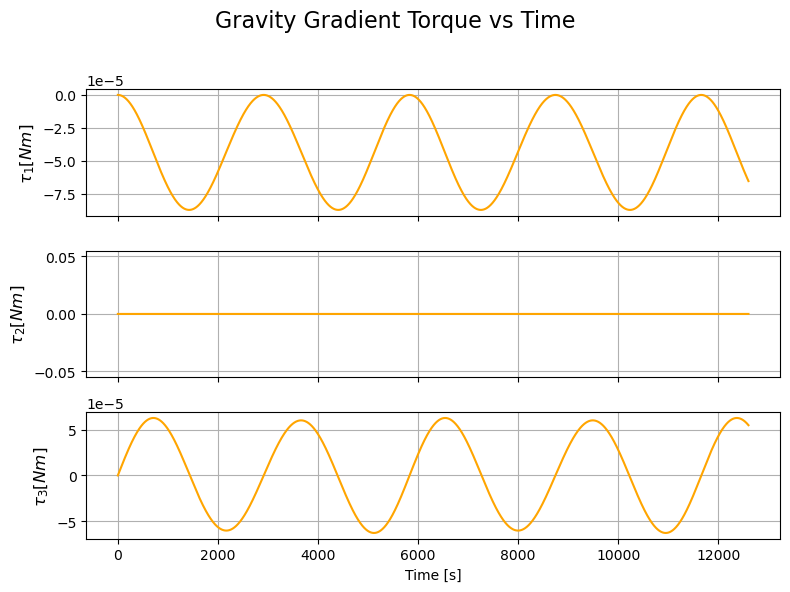

In [13]:
C = 3*mu/np.linalg.norm(xECI[:,:3],axis=1)**5
L_grav_1 = C*(xECI[:,1]*xECI[:,2]*(I[2,2]-I[1,1]))
L_grav_2 = C*(xECI[:,0]*xECI[:,2]*(I[0,0]-I[2,2]))
L_grav_3 = C*(xECI[:,0]*xECI[:,1]*(I[1,1]-I[0,0]))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, L in enumerate([L_grav_1, L_grav_2, L_grav_3]):
    axes[i].plot(times, L, color='orange')
    axes[i].set_ylabel(f"$\\tau_{i+1} [Nm]$",fontsize=12)
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Gravity Gradient Torque vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### (b) Comments
Examine the time histories of the ECI position vector components, X(t), Y (t), and Z(t) from problem 1.c. Comment on when $\tau_i^g= 0$ for i = 1, 2, 3.

What we see in this plot is that both Plates 1 and 3 generate a good amount of Gravity Gradient Torque, whereas Plate 2 does not generate any Gravity Gradient Torque. This makes sense, as the satellite is axis-symmetric about the $\hat{b}_2$ axis. Additionally, we see that torque about the $\hat{b}_1$ axis and the $\hat{b}_3$ axis oscillates as the satellite progresses about its orbit. Torque about the $\hat{b}_1$ axis starts at a maximum of 0 and decreases to its minimum value (negative), where it will then increase to its maximum again. The maximum occurs at the orbit perigee and at the orbit apogee, and the minimum occurs somewhere between. The torque about this axis is zero when the satellite is at apogee and perigee. Torque about the $\hat{b}_3$ axis has a similar behavior, except it starts at 0, and increases to its maximum value somewhere between the perigee and the apogee, the minimum value occurs between the apogee and the perigee. The torque about this axis is zero when the satellite is at apogee and perigee.

$\newpage$

## 6. Simulation of Uncontrolled Attitude Dynamics
The total torque on plate i of the satellite is the summation of the individual disturbance torques,
$$
\tau_i = \tau_i^{\text{aero}} + \tau_i^{\text{srp}} + \tau_i^{\text{mag}} + \tau_i^g 
\text{... for } i = 1, 2, 3
$$

The attitude dynamics of the satellite can be simulated by using the Euler’s equations for rotational motion,
$$
I_1 \dot{\omega}_1 = (I_2 - I_3) \omega_2 \omega_3 + \tau_1
$$
$$
I_2 \dot{\omega}_2 = (I_3 - I_1) \omega_3 \omega_1 + \tau_2
$$
$$
I_3 \dot{\omega}_3 = (I_1 - I_2) \omega_1 \omega_2 + \tau_3
$$

Note that by decoupling the disturbance torques from the spacecraft’s attitude, we simplified the computation of the torques and are able to integrate Euler’s equations to obtain the angular velocity time histories. However, in real-world simulations, the angular velocity, spacecraft attitude, and torques are all coupled and therefore must be integrated simultaneously within an ODE solver.

Perform the following tasks:

### (a) Computation and Plotting
Plot the time history of the total torque $\tau_i$, and overlay it with the time histories for the individual torques: $\tau_i^{\text{aero}}, \tau_i^{\text{srp}}, \tau_i^{\text{mag}}, \text{ and } \tau_i^g$ for i = 1, 2, 3.

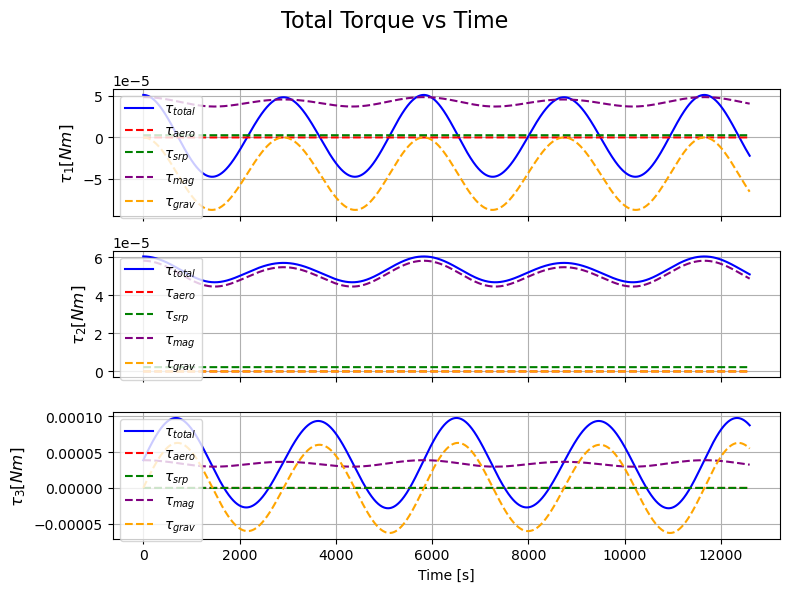

In [14]:
L_1 = L_aero_1+L_srp_1+L_mag_1+L_grav_1
L_2 = L_aero_2+L_srp_2+L_mag_2+L_grav_2
L_3 = L_aero_3+L_srp_3+L_mag_3+L_grav_3

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for i, (L, L_aero, L_srp, L_mag, L_grav) in enumerate(
    zip([L_1, L_2, L_3], [L_aero_1, L_aero_2, L_aero_3], 
        [L_srp_1, L_srp_2, L_srp_3], [L_mag_1, L_mag_2, L_mag_3], 
        [L_grav_1, L_grav_2, L_grav_3])
):
    axes[i].plot(times, L, label=r"$\tau_{total}$", color="blue")

    axes[i].plot(times, L_aero, label=r"$\tau_{aero}$", color="red", linestyle='dashed')
    axes[i].plot(times, np.ones_like(times) * L_srp, label=r"$\tau_{srp}$", color="green", linestyle='dashed')
    axes[i].plot(times, L_mag, label=r"$\tau_{mag}$", color="purple", linestyle='dashed')
    axes[i].plot(times, L_grav, label=r"$\tau_{grav}$", color="orange", linestyle='dashed')
    axes[i].legend(loc='upper left')
    axes[i].grid()

    axes[i].set_ylabel(f"$\\tau_{i+1} [Nm]$",fontsize=12)

axes[-1].set_xlabel("Time [s]")

fig.suptitle("Total Torque vs Time", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

$\newpage$

### (b) Numerical Integration and Plotting
Numerically integrate the Euler’s equations over a period of 3.5 hours using the given initial conditions on angular velocities and the time vector parameters. Plot these values.

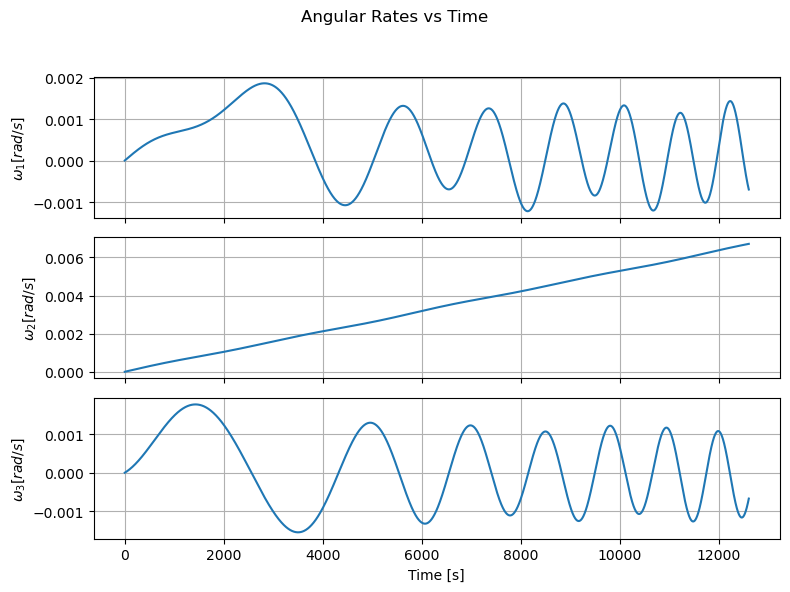

In [15]:
def Rotational_EOM(x,t,I):
    I1 = I[0,0]
    I2 = I[1,1]
    I3 = I[2,2]
    L1 = np.interp(t,times,L_1)
    L2 = np.interp(t,times,L_2)
    L3 = np.interp(t,times,L_3)
    return np.array([((I2-I3)*x[1]*x[2]+L1)/I1,
                     ((I3-I1)*x[2]*x[0]+L2)/I2,
                     ((I1-I2)*x[0]*x[1]+L3)/I3])

wBODY = odeint(Rotational_EOM,wBODY_0,times,args=(I,))

fig, axes = plt.subplots(3, 1, sharex=True,figsize=(8,6))
for i, y in enumerate([wBODY[:, 0], wBODY[:, 1], wBODY[:, 2]]):
    axes[i].plot(times, y)
    axes[i].set_ylabel(f"$\\omega_{i+1} [rad/s]$")
    axes[i].grid()
fig.suptitle("Angular Rates vs Time")
axes[2].set_xlabel("Time [s]")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### (c) Comments
Assuming the satellite attitude is described using the (3-2-1) Euler angle set ($\psi-\theta-\phi$) and given that we have obtained the time histories of the angular velocities in the body frame, what equation would you use to obtain the time histories for the Euler angles: $\psi(t)$, $\theta(t)$, and $\phi(t)$? Please answer using words, you do not need to perform a simulation for this question.

I would integrate the kinematic differential equation over time using the same ODE solver as before, given some initial conditions $\left[\begin{array}{c} \psi_0 \\ \theta_0 \\ \phi_0 \end{array}\right]$.
$$
\left[\begin{array}{ccc}
\dot{\psi} \\
\dot{\theta} \\
\dot{\phi}
\end{array}\right] = 
\left[\begin{array}{ccc}
0 && \frac{sin(\phi)}{cos(\theta)} && \frac{cos(\phi)}{cos(\theta)} \\
0 && cos(\phi) && -sin(\phi) \\
1 && sin(\phi)t(\theta) && cos(\phi)tan(\theta)
\end{array}\right]
\left[\begin{array}{ccc}
\omega_{1} \\
\omega_{2} \\
\omega_{3}
\end{array}\right]
$$